# Level 1: Local Frog Discovery Tool Notebook

### Load in dependencies

The following packages need to be imported in order to run this notebook.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV


# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
import pickle
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

We constrain our search to entire Australia, but for the years 2016 to 2020

In [3]:
# Define the bounding box
region_name = 'Australia'
min_lon, min_lat = (113.338953, -43.6345972) #(150.15, -34.25) Lower-left corner
max_lon, max_lat = (153.569469, -10.6681857) #(151.15, -33.25) # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2016, 2020), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
0,2574007008,2020-01-23 01:38:00,Australia,Australia,New South Wales,-32.719457,152.159267,Litoria Fallax
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
...,...,...,...,...,...,...,...,...
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera
193718,3468633397,2020-09-20 00:00:00,Australia,Australia,Victoria,-38.148540,144.361350,Crinia Signifera
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera


### Addressing bias


Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country.

In [4]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area

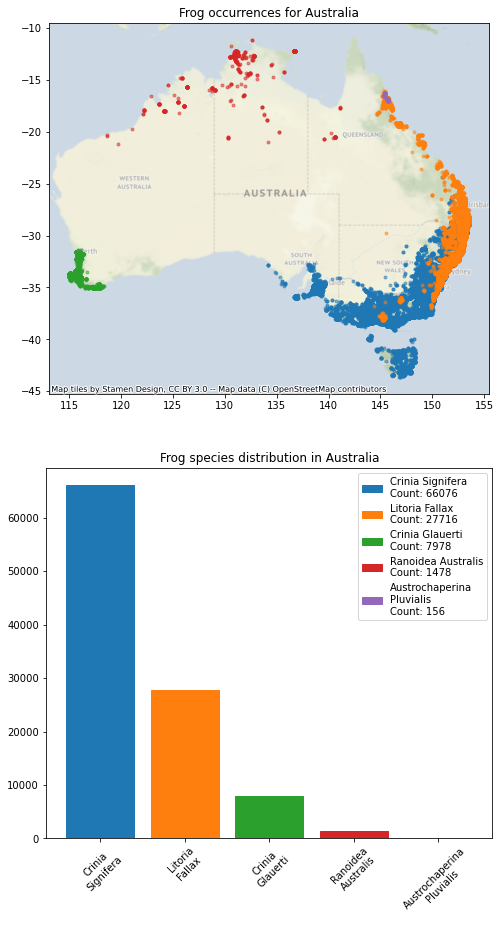

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc

Pseudo-absence technique is used to address this inherent sampling bias. We will alter our response variable to be occurenceStatus which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

In [6]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
0,2574007008,2020-01-23 01:38:00,Australia,Australia,New South Wales,-32.719457,152.159267,Litoria Fallax,1
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera,0
193718,3468633397,2020-09-20 00:00:00,Australia,Australia,Victoria,-38.148540,144.361350,Crinia Signifera,0
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera,0


#### Class Balancing

Another bias shown in the above visualisations is the class imbalance. A naive approach of down-sampling the absence points is used to match with the numbers that of the target species. 

Text(0.5, 1.0, 'Balanced training set')

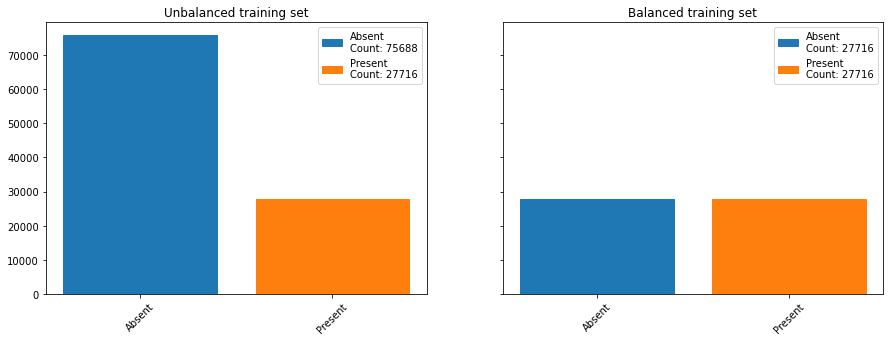

In [7]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

After assigning absence points and balancing the classes, we finally have our training data visualised below. 


Text(0.5, 1.0, 'Training set for Australia')

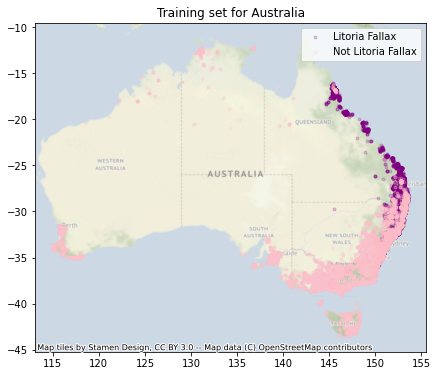

In [8]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'purple', marker='.', alpha=0.2, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'pink', marker='.', alpha=0.2, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. 

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2016 to the end of 2020.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [9]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [10]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2016-01-01','2020-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

### Visualising the TerraClimate Data

The spatial distribution of the four variables are displayed below.

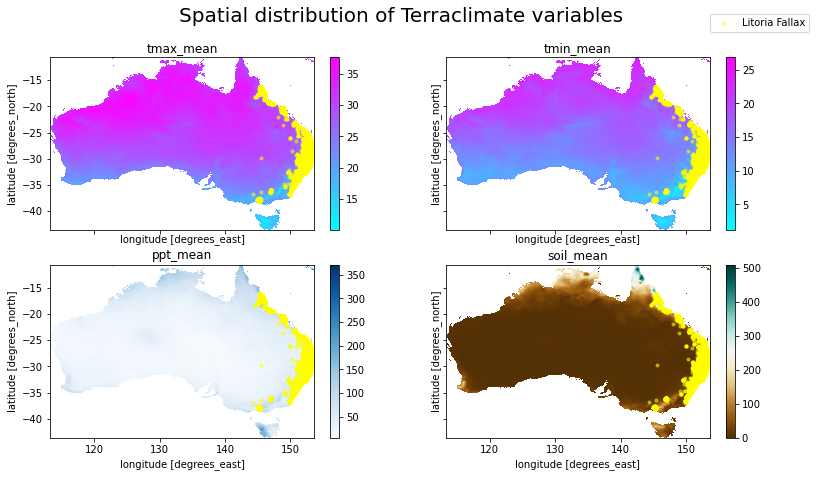

In [11]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

### Feature engineering

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model trained later, standardization may be required. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

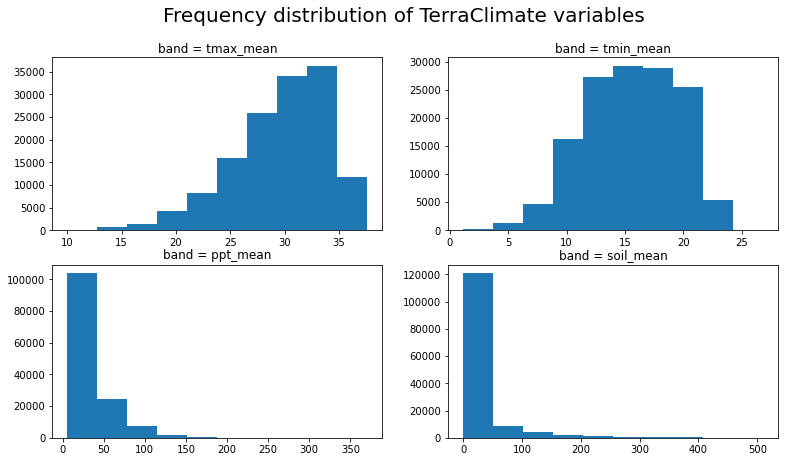

In [12]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Predictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [13]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3463581646,2020-03-09,Australia,Australia,New South Wales,-33.618652,151.142889,Crinia Signifera,0,0,86.645836,60.604168,23.177084,12.454167
1,3108868884,2019-09-03,Australia,Australia,New South Wales,-32.176900,149.795000,Crinia Signifera,0,1,46.458332,11.291667,23.583336,9.489585
2,3463469524,2020-11-06,Australia,Australia,New South Wales,-33.717100,150.426000,Crinia Signifera,0,2,84.291664,46.791668,20.835419,8.760418
3,3463616675,2018-08-12,Australia,Australia,Australian Capital Territory,-35.278300,149.109000,Crinia Signifera,0,3,46.187500,8.812500,21.125002,7.397918
4,3463680539,2020-04-08,Australia,Australia,New South Wales,-35.358931,149.304207,Crinia Signifera,0,4,49.000000,9.895833,19.293753,6.037501



## Model Selection, Training and Evaluation


### Data Prep
We wil be using Scikit-learn models in this notebook, which require separation of predictor variables and the response variable. We store the predictor variables in dataframe X and the response in the array y. 

We must further make sure to drop the response variable from X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too. Observations containing NA values are also dropped to avoid discrepancies in predictions and evaluation of the model later on. 

Once X and y variables are defined, we split them intro training and testing datasets, which wil later on be helpful to test our models with tuned hyperparameters.

In [14]:
usefuldata = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'key'], 1)
)

#np.any(np.isnan(usefuldata))

usefuldata = usefuldata.dropna(axis = 0)

X = usefuldata.drop('occurrenceStatus', 1)
y = usefuldata.occurrenceStatus.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 420, test_size = 0.2, stratify = y)

### Narrowing down choices of models 
We create a machine learning pipeline for 6 different base models which generally work well for SDMs: GradientBoosting Classifier, K-Nearest Neighbors, RandomForest Classifier, NaiveBayes Classifier, Support Vector Classifier, Logistic Regression. For each model, the data is pre-processed to be standardized (to take into account the skewed distributions seen earlier). 

In [24]:
pipe_gradientboosting=Pipeline([('scl',StandardScaler()),
                       ('clf',GradientBoostingClassifier())])
pipe_knn=Pipeline([('scl',StandardScaler()),
                  ('clf',KNeighborsClassifier(n_neighbors=3))])
pipe_randomforest = Pipeline([('scl',StandardScaler()),
                       ('clf', RandomForestClassifier(n_estimators = 100))])
pipe_naive = Pipeline([('scl',StandardScaler()),
                       ('clf',GaussianNB())])
pipe_svm = Pipeline([('scl',StandardScaler()),
                       ('clf',SVC())])
pipe_logistic = Pipeline([('scl',StandardScaler()),
                       ('clf', LogisticRegression())])

We then perform an in-sample evaluation to determine the models with the highest accuracy.

In [25]:
pipelines=[pipe_gradientboosting,pipe_knn, pipe_randomforest, pipe_naive, pipe_svm, pipe_logistic]
pipe_dict={0:'GradBoost',1:'KNN',
           2:'RandomFor', 3: 'NaiveBayes', 4: 'SVM', 5: 'LogReg'}

In [26]:
for pipe in pipelines:
    pipe.fit(X,y)

In [27]:
for idx,val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' %(pipe_dict[idx],val.score(X,y)))

GradBoost pipeline test accuracy: 0.821
KNN pipeline test accuracy: 0.691
RandomFor pipeline test accuracy: 0.856
NaiveBayes pipeline test accuracy: 0.743
SVM pipeline test accuracy: 0.805
LogReg pipeline test accuracy: 0.771


As shown above, the three models with highest accuracy are RandomForest, GradientBoosting, and SVM. Hence, in the next sections we proceed to hypertune the parameters of these models to further improve their accuracy and subsequently use a soft voting to produce better predictions. 

### RandomForest
A basic random forest model is used, as it was shown that hypertuning parameters for random forest gave a lower accuracy. 

In [30]:
rf_test = RandomForestClassifier(n_estimators = 100)
rf_test.fit(X_train, y_train)

RandomForestClassifier()

We also calculate the accuracy score of the model with our testing dataset.

In [31]:
y_pred = rf_test.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8473837209302325


### GradientBoost 
We tune the hyperparameters of a GradientBoosting model i.e. find the parameters that provide the best prediction for our model. A grid of parameters is created for the max_depth parameter. (no need to run for fitting the model)

In [32]:
max_depth = [6,7,8,9,10]

# Create the random grid
grid = {'max_depth' : max_depth}
gbc_test = GradientBoostingClassifier(n_estimators = 200)
gbc_cv = GridSearchCV(gbc_test, grid, cv = 3)
gbc_cv.fit(X_train, y_train)
gbc_cv.best_params_

{'max_depth': 7}

We also calculate the accuracy score of our selected model based on the grid search above. 

In [33]:
y_pred = gbc_cv.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8479287790697675


### SVM 
Similar method as above is used to hypertune parameters of other models. Here we hypertune parameters for SVM (no need to run to fit model). 

In [35]:
grid = {'C': [0.1,1,10], 'gamma': [1, 0.1],'kernel': ['rbf','sigmoid']}
svm_test = GridSearchCV(SVC(), grid, cv = 2)
svm_test.fit(X_train, y_train)
svm_test.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [37]:
y_pred = svm_test.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8441133720930233


### VotingClassifier 
We aim to further enhance our models by using the best of each of the models, and using soft voting from each of the model's prediction probability to create our final prediction output. We have also hypertuned the parameters of our voting classifier as shown below. (no need to run to fit model). 

In [38]:
# Number of trees in random forest
from sklearn.svm import SVC
rf = RandomForestClassifier(n_estimators = 100)
gradboost = GradientBoostingClassifier(n_estimators = 200, max_depth = 7)
svm = SVC(C = 10, gamma = 0.1, kernel = 'rbf')

weights = [(2,2,1), (3,3,2), (1,2,2), (2,1,2)]

# Create the random grid
grid = {"weights": weights}

classifiers = [("RandomForest", rf),("GradBoost", gradboost), ("svm", svm)]
vote1 = VotingClassifier(classifiers, voting = "soft")
voting_test = GridSearchCV(vote1, grid, cv = 5)
voting_test.fit(X, y)
voting_test.best_params_

{'weights': (2, 2, 1)}

### Fitting Chosen Model

The final model is fitted using the best parameters based on our hypertuning. The final model is a voting classifier of 3 models: RandomForest, GradientBoosting, and SVM. 

In [15]:
rf = RandomForestClassifier(n_estimators = 100)
gradboost = GradientBoostingClassifier(n_estimators = 200, max_depth = 7)
svm = SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability = True)

### 3 classifiers voting
full_model = VotingClassifier([("RandomForest", rf),("GradBoost", gradboost), ("svm", svm)], voting = "soft",
                         weights = (2, 2, 1))


# Fit model
full_model.fit(X, y)

VotingClassifier(estimators=[('RandomForest', RandomForestClassifier()),
                             ('GradBoost',
                              GradientBoostingClassifier(max_depth=7,
                                                         n_estimators=200)),
                             ('svm', SVC(C=10, gamma=0.1, probability=True))],
                 voting='soft', weights=(2, 2, 1))

### Model Prediction

#### Predict Training Set

To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [16]:
predictions= full_model.predict(X)

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 


In [17]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    
    '''PREDICT PROBA HERE'''
    probabilities[~null_pixels] = model.predict_proba(  
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. We will use `f1_score` and `accuracy_score` from Scikit-learn. 


In [43]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.86
Accuracy: 0.86


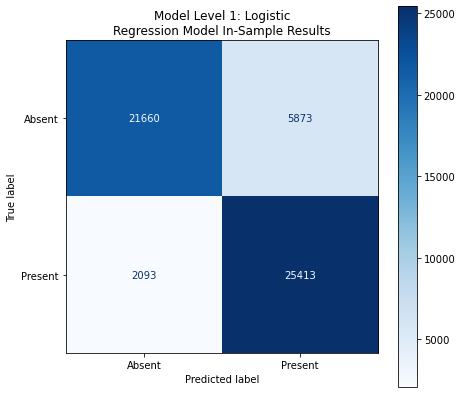

In [44]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#### Cross Validation 
To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 5. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 5 metrics which can be averaged, giving a more reliable and valid measure of model performance.

In [23]:
from sklearn.model_selection import cross_val_score
#change cv_model every time you want to test
classifiers = [("RandomForest", rf),("GradBoost", gradboost), ("KNN", knn)] 
cv_model = VotingClassifier([("RandomForest", rf),("GradBoost", gradboost), ("KNN", knn)], voting = "soft",
                         weights = (2, 2, 1)) #insert weights
cv_results = cross_val_score(cv_model, X, y, cv = 2)
cv_results.mean()

0.8219076868508185

In [45]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(full_model, X, y, cv = 5)
cv.mean()

0.8461633839380225

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

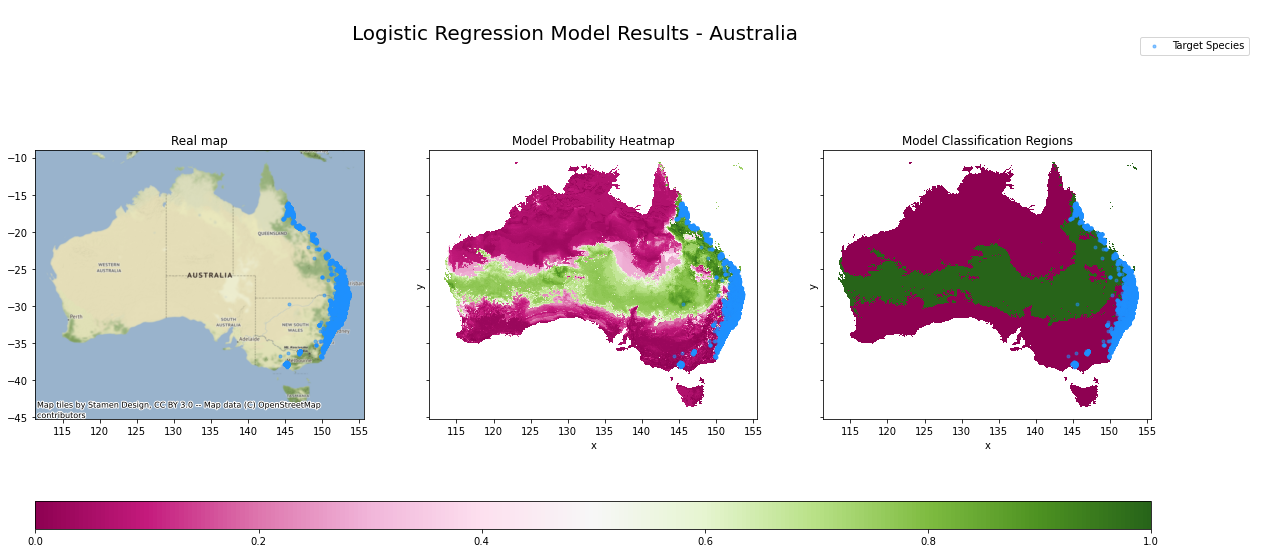

In [47]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")

### Feature Importance 
We also calculate the feature importance to find out which featuers in our model are the highest performing features. To aid us, we define the following function to calculate the feature importance for a voting classifier model. 

In [26]:
def compute_feature_importance(voting_clf, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        try: 
            feature_importance[str(est)] = est.feature_importances_
        except AttributeError: 
            feature_importance[str(est)] = est.intercept_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return fe_scores

The below table and importance plot sorts the features in its descending order of importance. As seen, mean soil moisture has the least importance. The mean maximum monthly air temperature and mean minimum monthly air temperature have the highest importance, while the mean accumulated precipitation has some level of importance. 

In [24]:
df_importance = pd.DataFrame()
df_importance['Feature'] = X_train.columns
df_importance['Feature Importance'] = compute_feature_importance(full_model, [2, 2, 1])
df_sorted = df_importance.sort_values('Feature Importance', ascending=False)
df_sorted

,Feature,Feature Importance
3,tmin_mean,1.330937
2,tmax_mean,0.946190
0,ppt_mean,0.541199
1,soil_mean,0.025337


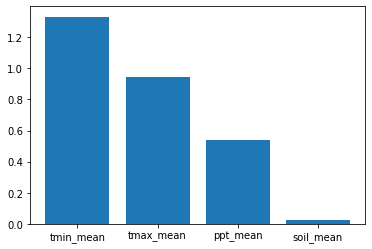

In [25]:
plt.bar(df_sorted['Feature'], df_sorted['Feature Importance'])
plt.show()

## Creating Model Object

We save our fitted model object in a pickle file. The following model will be validated in the model_validation_notebook.

In [49]:
filename = 'finalized_model.sav'
pickle.dump(full_model, open(filename, 'wb'))